loss is [5.5977602e+00 1.2977471e-03 5.5990582e+00]
loss is [1.8786237e+00 1.1279465e-03 1.8797517e+00]
loss is [1.5096104e+00 1.0971881e-04 1.5097201e+00]
loss is [0.02772556 0.00015255 0.02787811]
loss is [0.00491698 0.00054318 0.00546016]
loss is [3.1721845e-04 2.9327110e-08 3.1724779e-04]
loss is [1.0808608e-03 2.5072534e-06 1.0833681e-03]
loss is [3.9007384e-05 1.9320157e-09 3.9009316e-05]
loss is [1.8557748e-05 2.8808842e-08 1.8586557e-05]
loss is [5.8253048e-05 6.1794668e-07 5.8870995e-05]
loss is [1.0390655e-03 1.4524075e-07 1.0392108e-03]
loss is [0.00013668 0.00029984 0.00043652]
loss is [1.6207387e-05 2.3065411e-06 1.8513927e-05]
loss is [6.120802e-04 1.842859e-05 6.305088e-04]
loss is [1.2426841e-04 4.5605684e-06 1.2882898e-04]
loss is [2.6209063e-05 1.1936086e-05 3.8145150e-05]
loss is [2.5178408e-05 5.9373042e-07 2.5772139e-05]
loss is [4.1449657e-06 1.4526347e-09 4.1464182e-06]
loss is [1.5969052e-05 2.2344680e-06 1.8203520e-05]
loss is [3.011492e-07 7.190848e-08 3.73057

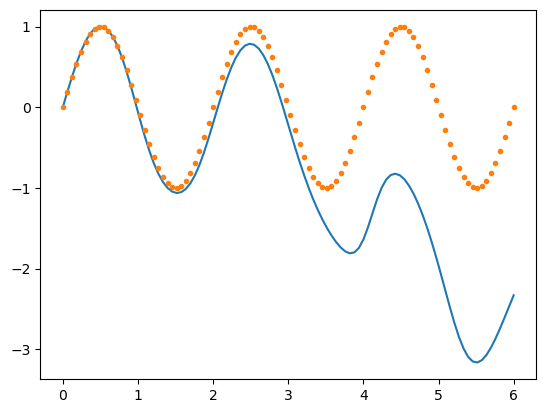

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

t_length = 6

## define a pde
pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num
pde_input = D1Field([0,t_length]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx - torch.pi * torch.cos(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

## define a bc
bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num
bc_input = np.array([[0]])
bc_output = np.zeros([bc_epoch_size ,1])
bc_batch_size = bc_epoch_size

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [1, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

epoch_num = 3000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

x_cpu = np.linspace(0,t_length,100).reshape(100,1)
y_cpu = solver.model_eval(x_cpu)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')